# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
import numpy as np
import glob
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/upgrad/neural_data/project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/upgrad/neural_data/project_data/val.csv').readlines())
batch_size = 10 #experiment with the batch size

In [ ]:
# Check for possible image dimensions
dimensions = []
for i in range(len(train_doc)):
  path = os.path.join('/content/drive/MyDrive/upgrad/neural_data/project_data/train', train_doc[i].split(';')[0], '*')
  path = glob.glob(path)
  img = imread(path[0])
  dimensions.append(img.shape)
# Extract unique values with set function
unique_dimensions = set(dimensions)
print("Total images : " +  str(len(dimensions)))
print("Image dimensions in training set : {}".format(unique_dimensions))

<ipython-input-39-2843679894bc>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(path[0])


Total images : 663
Image dimensions in training set : {(120, 160, 3), (360, 360, 3)}


### Conclusion

We have 663 images and possible widths are : 120 & 360, whereas possible heights are : 160 & 360.

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
IMG_SIZE = 120
CHANNELS = 3
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = list(range(0,30,2))#create a list of image numbers you want to use for a particular video
    print(len(img_idx))
    orig_batch_size = batch_size
    while True:
        t = np.random.permutation(folder_list)
        batch_size = orig_batch_size
        if(len(folder_list)%batch_size)==0:
            num_batches = int(len(folder_list)/batch_size)# calculate the number of batches
        else:
            num_batches = int((len(folder_list)//batch_size) + 1)# calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            if(batch==num_batches-1) and (len(folder_list)%batch_size)!=0:
                batch_size =  int(len(folder_list)%batch_size)
                print('for final batch, size is ',batch_size)
            batch_data = np.zeros((batch_size,len(img_idx),IMG_SIZE,IMG_SIZE,CHANNELS)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            act_batch_data = np.zeros((batch_size,len(img_idx),100352))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    image = resize(image, (IMG_SIZE, IMG_SIZE))
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0]))/np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1]))/np.std(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2]))/np.std(image[:,:,2])

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

                #act_batch_data[folder] = model.predict(batch_data[folder])
            #print('yielding batch now')
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


        # write the code for the remaining data points which are left after full batches

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/upgrad/neural_data/project_data/train'
val_path = '/content/drive/MyDrive/upgrad/neural_data/project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

num_classes = 5
print('# classes =', num_classes)

# training sequences = 663
# validation sequences = 100
# epochs = 10
# classes = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Input, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers, applications

#write your model here
STEPS = 15
inputs = Input(shape=(STEPS,IMG_SIZE,IMG_SIZE,CHANNELS),name='input')
output_1 = TimeDistributed(keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),name='Vgg16TimeDistribution')(inputs)
output_2 = TimeDistributed(Flatten())(output_1)
output_3 = GRU(500,return_sequences=False)(output_2)
predictions = Dense(5, activation='softmax')(output_3)

model = Model([inputs],predictions)
model.summary()













Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 120, 120, 3   0         
                             )]                                  
                                                                 
 Vgg16TimeDistribution (Tim  (None, 15, 3, 3, 512)     14714688  
 eDistributed)                                                   
                                                                 
 time_distributed_8 (TimeDi  (None, 15, 4608)          0         
 stributed)                                                      
                                                                 
 gru_8 (GRU)                 (None, 500)               7665000   
                                                                 
 dense_8 (Dense)             (None, 5)                 2505      
                                                           

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
for layer in model.layers:
    if layer.name == 'Vgg16TimeDistribution':
        layer.trainable = False

In [ ]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 120, 120, 3   0         
                             )]                                  
                                                                 
 Vgg16TimeDistribution (Tim  (None, 15, 3, 3, 512)     14714688  
 eDistributed)                                                   
                                                                 
 time_distributed_8 (TimeDi  (None, 15, 4608)          0         
 stributed)                                                      
                                                                 
 gru_8 (GRU)                 (None, 500)               7665000   
                                                                 
 dense_8 (Dense)             (None, 5)                 2505      
                                                           

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
print('num_train_sequences',len(train_doc))
print('num_val_sequences',len(val_doc))
print('batch size',batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
print('steps_per_epoch',steps_per_epoch)
print('validation_steps',validation_steps)

num_train_sequences 663
num_val_sequences 100
batch size 13
steps_per_epoch 51
validation_steps 8


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=5,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1)

Source path =  /content/drive/MyDrive/upgrad/neural_data/project_data/train ; batch size = 13
15


<ipython-input-89-5f0324ed02b3>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])


Epoch 1/10
Source path =  /content/drive/MyDrive/upgrad/neural_data/project_data/val ; batch size = 13
15
for final batch, size is  9

Epoch 1: saving model to model_init_2024-06-0523_21_43.156257/model-00001-1.40424-0.57466-0.65446-0.76000.h5
Epoch 2/10
for final batch, size is  9

Epoch 2: saving model to model_init_2024-06-0523_21_43.156257/model-00002-0.21791-0.94118-0.53154-0.80000.h5
Epoch 3/10
for final batch, size is  9

Epoch 3: saving model to model_init_2024-06-0523_21_43.156257/model-00003-0.05289-0.99095-0.43717-0.78000.h5
Epoch 4/10
for final batch, size is  9

Epoch 4: saving model to model_init_2024-06-0523_21_43.156257/model-00004-0.01230-1.00000-0.52018-0.76000.h5
Epoch 5/10
for final batch, size is  9

Epoch 5: saving model to model_init_2024-06-0523_21_43.156257/model-00005-0.00536-1.00000-0.47947-0.82000.h5
Epoch 6/10
for final batch, size is  9

Epoch 6: saving model to model_init_2024-06-0523_21_43.156257/model-00006-0.00322-1.00000-0.47091-0.78000.h5
Epoch 7/10


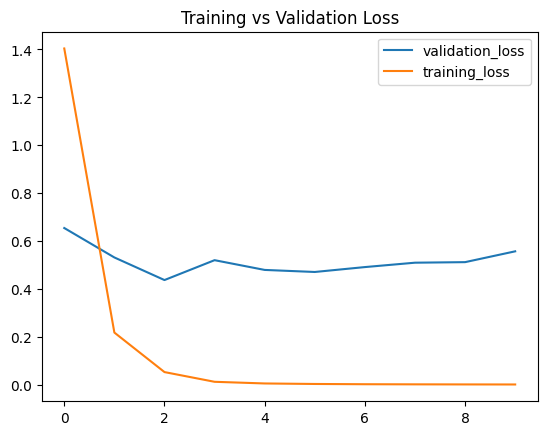

In [ ]:
plt.figure()
plt.title('Training vs Validation Loss')
plt.plot(range(0,10),model.history.history['val_loss'],label='validation_loss')
plt.plot(range(0,10),model.history.history['loss'],label='training_loss')
plt.legend()
plt.show()

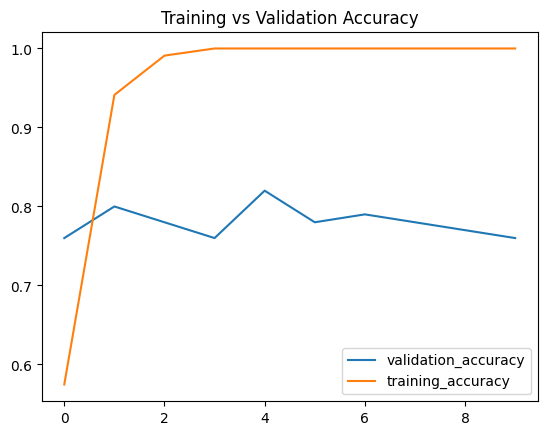

In [ ]:
plt.figure()
plt.title('Training vs Validation Accuracy')
plt.plot(range(0,10),model.history.history['val_categorical_accuracy'],label='validation_accuracy')
plt.plot(range(0,10),model.history.history['categorical_accuracy'],label='training_accuracy')
plt.legend()
plt.show()

In [ ]:
#Model Optimization
STEPS = 15
inputs = Input(shape=(STEPS,IMG_SIZE,IMG_SIZE,CHANNELS),name='input')
output_1 = TimeDistributed(keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),name='Vgg16TimeDistribution')(inputs)
output_2 = TimeDistributed(keras.layers.Dropout(0.9))(output_1)
output_3 = TimeDistributed(keras.layers.BatchNormalization())(output_2)
output_4 = TimeDistributed(Flatten())(output_3)
output_5 = GRU(300,return_sequences=False)(output_4)
predictions = Dense(5, activation='softmax')(output_5)

model_2 = Model([inputs],predictions)
model_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 120, 120, 3   0         
                             )]                                  
                                                                 
 Vgg16TimeDistribution (Tim  (None, 15, 3, 3, 512)     14714688  
 eDistributed)                                                   
                                                                 
 time_distributed_9 (TimeDi  (None, 15, 3, 3, 512)     0         
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 15, 3, 3, 512)     2048      
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 15, 4608)          0   

In [ ]:
for layer in model_2.layers:
    if layer.name == 'Vgg16TimeDistribution':
        layer.trainable = False

In [ ]:
model_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 120, 120, 3   0         
                             )]                                  
                                                                 
 Vgg16TimeDistribution (Tim  (None, 15, 3, 3, 512)     14714688  
 eDistributed)                                                   
                                                                 
 time_distributed_9 (TimeDi  (None, 15, 3, 3, 512)     0         
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, 15, 3, 3, 512)     2048      
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, 15, 4608)          0   

In [ ]:
optimiser = keras.optimizers.Adam()#write your optimizer
model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model_name = 'model2_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=5, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2)

callbacks_list = [checkpoint, LR]

In [ ]:
history2 = model_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=5,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None)

<ipython-input-89-5f0324ed02b3>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])


Epoch 1/10
for final batch, size is  9

Epoch 1: val_loss improved from inf to 0.76539, saving model to model2_init_2024-06-0523_40_50.807316/model-00001-1.34567-0.45551-0.76539-0.78000.h5
Epoch 2/10
for final batch, size is  9

Epoch 2: val_loss improved from 0.76539 to 0.54807, saving model to model2_init_2024-06-0523_40_50.807316/model-00002-0.65976-0.76320-0.54807-0.74000.h5
Epoch 3/10
for final batch, size is  9

Epoch 3: val_loss did not improve from 0.54807
Epoch 4/10
for final batch, size is  9

Epoch 4: val_loss did not improve from 0.54807
Epoch 5/10
for final batch, size is  9

Epoch 5: val_loss did not improve from 0.54807
Epoch 6/10
for final batch, size is  9
for final batch, size is  9

Epoch 6: val_loss did not improve from 0.54807
Epoch 7/10
for final batch, size is  9

Epoch 7: val_loss did not improve from 0.54807
Epoch 8/10
for final batch, size is  9

Epoch 8: val_loss did not improve from 0.54807
Epoch 9/10
for final batch, size is  9

Epoch 9: val_loss did not im

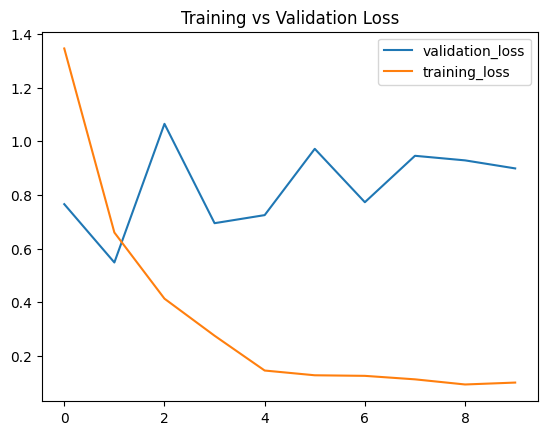

In [ ]:
plt.figure()
plt.title('Training vs Validation Loss')
plt.plot(range(0,10),model_2.history.history['val_loss'],label='validation_loss')
plt.plot(range(0,10),model_2.history.history['loss'],label='training_loss')
plt.legend()
plt.show()

### Conclusion
1. There is a huge gap between training loss and validation loss.
2. Training loss reduced but validation loss stayed high.
3. This is an indicator of overfitting.

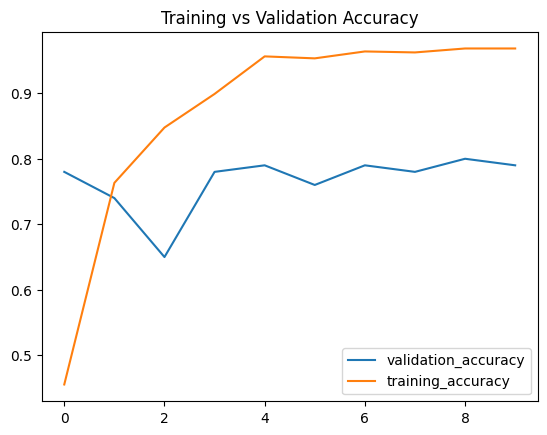

In [ ]:
plt.figure()
plt.title('Training vs Validation Accuracy')
plt.plot(range(0,10),model_2.history.history['val_categorical_accuracy'],label='validation_accuracy')
plt.plot(range(0,10),model_2.history.history['categorical_accuracy'],label='training_accuracy')
plt.legend()
plt.show()

### Conclusion
1. Training accuracy increased over every iteration.
2. Validation accuracy lagged behind training accuracy.
3. High training accuracy and low training accuracy indicates overfitting.

In [ ]:
#Model Optimization
STEPS = 15
inputs = Input(shape=(STEPS,IMG_SIZE,IMG_SIZE,CHANNELS),name='input')
#input_1 = keras.layers.Dropout(0.2)(inputs)
output_1 = TimeDistributed(keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),name='Vgg16TimeDistribution')(inputs)
output_2 = TimeDistributed(keras.layers.Dropout(0.8))(output_1)
output_3 = TimeDistributed(keras.layers.BatchNormalization())(output_2)
output_4 = TimeDistributed(Flatten())(output_3)
output_5 = GRU(100,return_sequences=False)(output_4)
output_6 = keras.layers.Dropout(0.8)(output_5)
output_7 = keras.layers.BatchNormalization()(output_6)
predictions = Dense(5, activation='softmax')(output_7)

model_3 = Model([inputs],predictions)
model_3.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 120, 120, 3   0         
                             )]                                  
                                                                 
 Vgg16TimeDistribution (Tim  (None, 15, 3, 3, 512)     14714688  
 eDistributed)                                                   
                                                                 
 time_distributed_12 (TimeD  (None, 15, 3, 3, 512)     0         
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 15, 3, 3, 512)     2048      
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 15, 4608)          0  

In [ ]:
for layer in model_3.layers:
    if layer.name == 'Vgg16TimeDistribution':
        layer.trainable = False

In [ ]:
model_3.summary()


Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 120, 120, 3   0         
                             )]                                  
                                                                 
 Vgg16TimeDistribution (Tim  (None, 15, 3, 3, 512)     14714688  
 eDistributed)                                                   
                                                                 
 time_distributed_12 (TimeD  (None, 15, 3, 3, 512)     0         
 istributed)                                                     
                                                                 
 time_distributed_13 (TimeD  (None, 15, 3, 3, 512)     2048      
 istributed)                                                     
                                                                 
 time_distributed_14 (TimeD  (None, 15, 4608)          0  

In [ ]:
optimiser = keras.optimizers.RMSprop()#write your optimizer
model_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model_name = 'model3_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=5, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2)

callbacks_list = [checkpoint, LR]

In [ ]:
model_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=5,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None)

<ipython-input-89-5f0324ed02b3>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])


Epoch 1/10
for final batch, size is  9

Epoch 1: val_loss improved from inf to 1.08976, saving model to model3_init_2024-06-0523_40_50.807316/model-00001-1.90536-0.28507-1.08976-0.59000.h5
Epoch 2/10
for final batch, size is  9

Epoch 2: val_loss improved from 1.08976 to 0.99564, saving model to model3_init_2024-06-0523_40_50.807316/model-00002-1.60986-0.37104-0.99564-0.59000.h5
Epoch 3/10
for final batch, size is  9

Epoch 3: val_loss improved from 0.99564 to 0.80784, saving model to model3_init_2024-06-0523_40_50.807316/model-00003-1.38589-0.45400-0.80784-0.68000.h5
Epoch 4/10
for final batch, size is  9
for final batch, size is  9

Epoch 4: val_loss improved from 0.80784 to 0.72344, saving model to model3_init_2024-06-0523_40_50.807316/model-00004-1.06539-0.55505-0.72344-0.71000.h5
Epoch 5/10
for final batch, size is  9

Epoch 5: val_loss improved from 0.72344 to 0.62044, saving model to model3_init_2024-06-0523_40_50.807316/model-00005-0.91412-0.64857-0.62044-0.77000.h5
Epoch 6/10


### Conclusion

1. After applying GRU, BatchOptimization and Dropout, validation loss improved a little to 0.51.

In [ ]:
#Model Optimization using bidirectional GRU layer
STEPS = 15
inputs = Input(shape=(STEPS,IMG_SIZE,IMG_SIZE,CHANNELS),name='input')
#input_1 = keras.layers.Dropout(0.2)(inputs)
output_1 = TimeDistributed(keras.applications.vgg16.VGG16(weights='imagenet',include_top=False,input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)),name='Vgg16TimeDistribution')(inputs)
output_2 = TimeDistributed(keras.layers.Dropout(0.8))(output_1)
output_3 = TimeDistributed(keras.layers.BatchNormalization())(output_2)
output_4 = TimeDistributed(Flatten())(output_3)
output_5 = keras.layers.Bidirectional(GRU(100,return_sequences=False))(output_4)
output_6 = keras.layers.Dropout(0.8)(output_5)
output_7 = keras.layers.BatchNormalization()(output_6)
predictions = Dense(5, activation='softmax')(output_7)

model_4 = Model([inputs],predictions)
model_4.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 120, 120, 3   0         
                             )]                                  
                                                                 
 Vgg16TimeDistribution (Tim  (None, 15, 3, 3, 512)     14714688  
 eDistributed)                                                   
                                                                 
 time_distributed_15 (TimeD  (None, 15, 3, 3, 512)     0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 15, 3, 3, 512)     2048      
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 15, 4608)          0  

In [ ]:
for layer in model_4.layers:
    if layer.name == 'Vgg16TimeDistribution':
        layer.trainable = False

In [ ]:
model_4.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 15, 120, 120, 3   0         
                             )]                                  
                                                                 
 Vgg16TimeDistribution (Tim  (None, 15, 3, 3, 512)     14714688  
 eDistributed)                                                   
                                                                 
 time_distributed_15 (TimeD  (None, 15, 3, 3, 512)     0         
 istributed)                                                     
                                                                 
 time_distributed_16 (TimeD  (None, 15, 3, 3, 512)     2048      
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 15, 4608)          0  

In [ ]:
optimiser = keras.optimizers.RMSprop() #write your optimizer
model_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [119]:
model_name = 'model4_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=5, save_best_only=True, save_weights_only=True, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2)

callbacks_list = [checkpoint, LR]

In [ ]:
model_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=5,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None)

<ipython-input-89-5f0324ed02b3>:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])


Epoch 1/10
for final batch, size is  9

Epoch 1: val_loss improved from inf to 1.03533, saving model to model4_init_2024-06-0523_40_50.807316/model-00001-1.89477-0.31071-1.03533-0.57000.h5
Epoch 2/10
for final batch, size is  9
for final batch, size is  9

Epoch 2: val_loss improved from 1.03533 to 0.87287, saving model to model4_init_2024-06-0523_40_50.807316/model-00002-1.41116-0.45852-0.87287-0.68000.h5
Epoch 3/10
for final batch, size is  9

Epoch 3: val_loss improved from 0.87287 to 0.67197, saving model to model4_init_2024-06-0523_40_50.807316/model-00003-1.22793-0.51131-0.67197-0.77000.h5
Epoch 4/10
for final batch, size is  9

Epoch 4: val_loss improved from 0.67197 to 0.56597, saving model to model4_init_2024-06-0523_40_50.807316/model-00004-1.01861-0.62443-0.56597-0.83000.h5
Epoch 5/10
for final batch, size is  9

Epoch 5: val_loss improved from 0.56597 to 0.41054, saving model to model4_init_2024-06-0523_40_50.807316/model-00005-0.81481-0.70739-0.41054-0.87000.h5
Epoch 6/10


### Conclusion

1. Adding the Bidirectional GRU, validation loss fell to 0.41.

### Trying Conv3D Library to create model

In [129]:
train_path = '/content/drive/MyDrive/upgrad/neural_data/project_data/train'
val_path = '/content/drive/MyDrive/upgrad/neural_data/project_data/val'
num_train_sequences = len(train_doc) #change training data size for initial phase
num_val_sequences = len(val_doc) #val training data can be kept as such
num_epochs = 10 # choose the number of epochs
batch_size = 15 #experiment with the batch size

### Generators

In [130]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    #note using alternate 15 images here
    img_idx = list(range(0,30,2))#create a list of image numbers you want to use for a particular video
    #img_idx = list(range(5, 25)) #taking middle frames only
    orig_batch_size = batch_size
    while True:

        t = np.random.permutation(folder_list)
        batch_size = orig_batch_size
        if(len(folder_list)%batch_size)==0:
            num_batches = int(len(folder_list)/batch_size)# calculate the number of batches
        else:
            num_batches = int((len(folder_list)//batch_size) + 1)# calculate the number of batches

        for batch in range(num_batches): # we iterate over the number of batches

            if(batch==num_batches-1) and (len(folder_list)%batch_size)!=0:
                batch_size =  int(len(folder_list)%batch_size)
                #print('for final batch, size is ',batch_size)

            batch_data = np.zeros((batch_size,len(img_idx),IMG_SIZE,IMG_SIZE,CHANNELS)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output

            #act_batch_data = np.zeros((batch_size,len(img_idx),100352))
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    #print('img_idx',img_idx)
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                    #print('read image')
                    image = resize(image, (IMG_SIZE, IMG_SIZE))
                    #(image[:,:,0] - np.mean(image[:,:,0]))/np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.mean(image[:,:,0]))/np.std(image[:,:,0])
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.mean(image[:,:,1]))/np.std(image[:,:,1])
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.mean(image[:,:,2]))/np.std(image[:,:,2])
                    #(image[:,:,2] - np.percentile(image[:,:,2], 5))/(np.percentile(image[:,:,2], 95) - np.percentile(image[:,:,2], 5))

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

### Callbacks

In [131]:
curr_dt_time = datetime.datetime.now()
model_name = 'model3d_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=True, mode='auto', period=1)

#pateince = after how many epochs the learning rate should be reduced.
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4 , cooldown=1, verbose=1)
callbacks_list = [LR, checkpoint]

#### Steps per Epoch, Validation steps

In [132]:
print('num_train_sequences',len(train_doc))
print('num_val_sequences',len(val_doc))
print('batch size',batch_size)
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
print('steps_per_epoch',steps_per_epoch)
print('validation_steps',validation_steps)

num_train_sequences 663
num_val_sequences 100
batch size 15
steps_per_epoch 45
validation_steps 7


In [133]:
model_conv3d = Sequential()

model_conv3d.add(Conv3D(16, kernel_size=(3, 3, 3), activation = 'relu', input_shape = (15, 120, 120, 3), padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_conv3d.add(Conv3D(32, kernel_size = (3, 3, 3), activation = 'relu', padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(MaxPooling3D(pool_size=(1, 2, 2), strides = (1,2,2)))

model_conv3d.add(Conv3D(64, kernel_size = (3, 3, 3), activation = 'relu', padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_conv3d.add(Conv3D(128, kernel_size = (3, 3, 3), activation = 'relu', padding='same'))
model_conv3d.add(BatchNormalization())
model_conv3d.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_conv3d.add(Flatten())
model_conv3d.add(Dropout(0.5))
model_conv3d.add(Dense(128, activation='relu'))
model_conv3d.add(Dropout(0.5))

model_conv3d.add(Dense(5, activation = 'softmax'))

In [134]:
model_conv3d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 15, 120, 120, 16   1312      
                             )                                   
                                                                 
 batch_normalization_9 (Bat  (None, 15, 120, 120, 16   64        
 chNormalization)            )                                   
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 7, 60, 60, 16)     0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 7, 60, 60, 32)     13856     
                                                                 
 batch_normalization_10 (Ba  (None, 7, 60, 60, 32)     128       
 tchNormalization)                                    

In [135]:
optimiser = optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [136]:
# Fit the model
model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Source path =  /content/drive/MyDrive/upgrad/neural_data/project_data/train ; batch size = 15


<ipython-input-130-214cc48a916f>:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])


Epoch 1/10
45/45 [==============================] - ETA: 0s - loss: 0.0352 - categorical_accuracy: 0.9894Source path =  /content/drive/MyDrive/upgrad/neural_data/project_data/val ; batch size = 15

Epoch 1: saving model to model3d_init_2024-06-0601_11_39.432600/model-00001-0.03518-0.98944-1.43141-0.64000.h5
45/45 [==============================] - 132s 3s/step - loss: 0.0352 - categorical_accuracy: 0.9894 - val_loss: 1.4314 - val_categorical_accuracy: 0.6400 - lr: 0.0010
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 0.0904 - categorical_accuracy: 0.9729
Epoch 2: saving model to model3d_init_2024-06-0601_11_39.432600/model-00002-0.09040-0.97285-0.77591-0.72000.h5
45/45 [==============================] - 119s 3s/step - loss: 0.0904 - categorical_accuracy: 0.9729 - val_loss: 0.7759 - val_categorical_accuracy: 0.7200 - lr: 0.0010
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 0.0286 - categorical_accuracy: 0.9910
Epoch 3: saving model to model3d_i

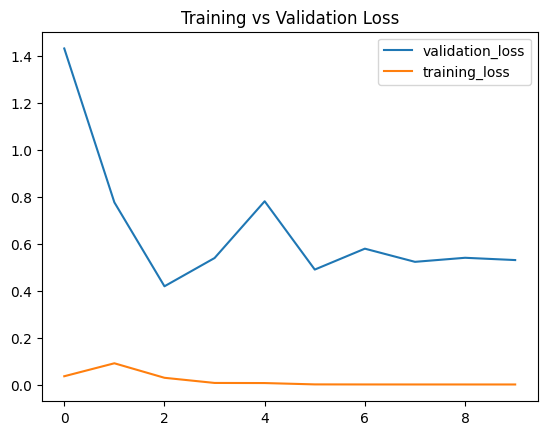

In [137]:
plt.figure()
plt.title('Training vs Validation Loss')
plt.plot(range(0,10),model.history.history['val_loss'],label='validation_loss')
plt.plot(range(0,10),model.history.history['loss'],label='training_loss')
plt.legend()
plt.show()

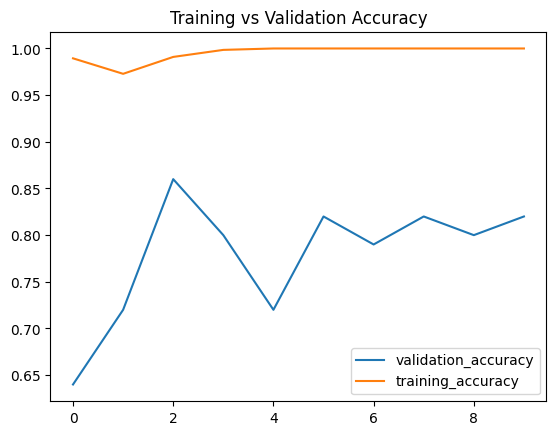

In [138]:
plt.figure()
plt.title('Training vs Validation Accuracy')
plt.plot(range(0,10),model.history.history['val_categorical_accuracy'],label='validation_accuracy')
plt.plot(range(0,10),model.history.history['categorical_accuracy'],label='training_accuracy')
plt.legend()
plt.show()

### Summary

The CONV3D model also shows the problem of overfitting, but in the first iteration itself, it has achieved better accuracy and reduced loss for both validation data and training data.

Lot many improvements, experiments and variations can be added to improve these models, but due to limited computing resources, it is not possible to achieve. Even on Google Colab, training the model and machine learning is taking a lot of time.